In [1]:
# Settings
NUM_OF_CLASSES = 35
IMAGE_SIZE_REDUCE_FACTOR = 3

# Hyperparams
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
DROPOUT = 0.5

# Dense Block Hyperparams
NUM_DBS = 4
NUM_LAYERS_PER_DB = 3
NUM_FILTERS_PER_LAYER_OF_DB = 4

In [2]:
# Load Ontology
import pandas as pd

ontology = pd.read_csv("ontology.csv")[["class_name", "output_value", "display_color"]].values.tolist()
colors = {v[0]: v[2] for v in ontology}
ontology = {v[0]: v[1] for v in ontology}

# Remove extra classes
del ontology["void"]
del ontology["uphill"]
del ontology["downhill"]

# Process colors
colors = {c: (int(colors[c][1:3], 16), int(colors[c][3:5], 16), int(colors[c][5:7], 16)) for c in ontology.keys()}

# Convert ontology to color map
ontology_labels = list(ontology.keys())
ontology = [i in ontology.values() for i in range(NUM_OF_CLASSES)]

NUM_OF_CLASSES = ontology.count(True)

In [3]:
# Open tensorflow and init both GPUs
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

dist_strategy = tf.distribute.MirroredStrategy()

2023-12-15 09:14:21.876015: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 09:14:21.946571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 09:14:22.718014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-12-15 09:14:23.848445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22254 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2023-12-15 09:14:23.849003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22451 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


In [4]:
# Load pre-downsized images
import numpy as np

# These files are my own compressed directories including the full color images, the one hot labels.  They are also absolutely massive.
# Alternatively, the dataset is here: https://github.com/unmannedlab/RELLIS-3D
with np.load("train.npz") as data:
    x_train, y_train = data["img_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)

with np.load("val.npz") as data:
    x_val, y_val = data["img_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)

with tf.device("cpu:0"):
    train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
    del x_train, y_train
    val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
    del x_val, y_val

train = train.map(lambda x, y: (x, tf.math.argmax(y, axis=-1))).cache()
val = val.map(lambda x, y: (x, tf.math.argmax(y, axis=-1))).cache()

In [5]:
# Create pre-defined layers
# Layers are created from the code implementation of the original paper:
# https://github.com/SimJeg/FC-DenseNet/tree/master
from tensorflow.keras import layers

def create_dense_block(x, num_of_layers, num_filters, kernel_size=5):
    output_layers = [x]
    for l in range(num_of_layers):
        x = layers.Conv2D(num_filters, kernel_size, activation="elu", padding="same")(x)
        output_layers.append(x)
        x = layers.Concatenate()(output_layers)
        x = layers.Dropout(DROPOUT)(x)
    return x

def create_transistion_down(x, layer_size_change, num_filters=None):
    if num_filters:
        x = layers.Conv2D(num_filters, 1, activation="elu", padding="same")(x)
    
    return layers.MaxPool2D(layer_size_change)(x)

def create_transistion_up(x, layer_size_change, num_filters):
    return layers.Conv2DTranspose(num_filters, 1, strides=layer_size_change, activation="elu", padding="same")(x)


In [6]:
# Create model
from tensorflow.keras import models, optimizers, metrics

# Keep track for skip connections and other things
skip_connections = []
previous_filters = [NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB]

# https://stackoverflow.com/a/71310084 says to put this here (TF bug)
with dist_strategy.scope():
    model_in = layers.Input(shape=train.element_spec[0].shape[1:])
    x = layers.Conv2D(previous_filters[-1], 9, activation="elu", padding="same")(model_in)

    for i in range(NUM_DBS):
        previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
        x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1])
        skip_connections.append(x)
        x = create_transistion_down(x, 2, num_filters=(previous_filters[-1]))


    previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
    x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1])
    del previous_filters[-1]

    for filters, skip in zip(previous_filters[::-1], skip_connections[::-1]):
        x = create_transistion_up(x, 2, num_filters=filters)
        x = layers.Concatenate()([x, skip])
        x = create_dense_block(x, NUM_LAYERS_PER_DB, filters)

    x = layers.Conv2D(NUM_OF_CLASSES, 5, 1, activation="softmax", padding="same")(x)

    opt = optimizers.Adam(learning_rate=LEARNING_RATE)

    model_metrics = [
        metrics.SparseTopKCategoricalAccuracy(k=1, name='Top 1 Accuracy'),
        metrics.SparseTopKCategoricalAccuracy(k=3, name='Top 3 Accuracy'),
        metrics.SparseTopKCategoricalAccuracy(k=5, name='Top 5 Accuracy'),
        metrics.MeanIoU(num_classes=NUM_OF_CLASSES, sparse_y_true=True, sparse_y_pred=False, name="Mean IoU")
    ]


    dense_net = models.Model(model_in, x)
    dense_net.compile(opt, loss="sparse_categorical_crossentropy", metrics=model_metrics)

dense_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 640, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 640, 12)         2928      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 400, 640, 24)         7224      ['conv2d[0][0]']              
                                                                                                  
 concatenate (Concatenate)   (None, 400, 640, 36)         0         ['conv2d[0][0]',              
                                                                     'conv2d_1[0][0]']        

In [7]:
# Fit model
from tensorflow.keras.callbacks import EarlyStopping

dense_net.fit(
    train,
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    validation_data = val,
    validation_batch_size = BATCH_SIZE
)

2023-12-15 09:16:54.121915: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_HALF
      type: DT_HALF
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 3301
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 400
        }
        dim {
          size: 640
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 400
        }
        dim {
          size: 640
        }
        dim {
          size: 19
        }
  

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 74 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devi

2023-12-15 09:17:18.050543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-15 09:17:20.205620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-15 09:17:20.264206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-15 09:17:20.379123: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-15 09:17:20.379150: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-12-15 09:17:20.379246: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx co

207/207 [==============================] - ETA: 0s - loss: 0.9508 - Top 1 Accuracy: 0.6764 - Top 3 Accuracy: 0.9240 - Top 5 Accuracy: 0.9646 - Mean IoU: 0.1063

2023-12-15 09:22:23.578929: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_HALF
      type: DT_HALF
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 979
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:2"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 400
        }
        dim {
          size: 640
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 400
        }
        dim {
          size: 640
        }
        dim {
          size: 19
        }
   

207/207 [==============================] - 351s 1s/step - loss: 0.9508 - Top 1 Accuracy: 0.6764 - Top 3 Accuracy: 0.9240 - Top 5 Accuracy: 0.9646 - Mean IoU: 0.1063 - val_loss: 2.2868 - val_Top 1 Accuracy: 0.4543 - val_Top 3 Accuracy: 0.6489 - val_Top 5 Accuracy: 0.7417 - val_Mean IoU: 0.0598
Epoch 2/100
207/207 [==============================] - 222s 1s/step - loss: 0.6221 - Top 1 Accuracy: 0.7927 - Top 3 Accuracy: 0.9710 - Top 5 Accuracy: 0.9882 - Mean IoU: 0.1716 - val_loss: 3.5631 - val_Top 1 Accuracy: 0.4896 - val_Top 3 Accuracy: 0.6535 - val_Top 5 Accuracy: 0.7097 - val_Mean IoU: 0.1017
Epoch 3/100
207/207 [==============================] - 224s 1s/step - loss: 0.5083 - Top 1 Accuracy: 0.8290 - Top 3 Accuracy: 0.9802 - Top 5 Accuracy: 0.9919 - Mean IoU: 0.2083 - val_loss: 2.0789 - val_Top 1 Accuracy: 0.6441 - val_Top 3 Accuracy: 0.8217 - val_Top 5 Accuracy: 0.8811 - val_Mean IoU: 0.1428
Epoch 4/100
207/207 [==============================] - 225s 1s/step - loss: 0.4683 - Top 1 Acc


KeyboardInterrupt



In [8]:
# Save model
dense_net.save("dense_net_final_proj.tf", save_format="tf")

# It is important that we save the model and reload it, as this will
# reset the tf distributed strategy

INFO:tensorflow:Assets written to: dense_net_final_proj.tf/assets


INFO:tensorflow:Assets written to: dense_net_final_proj.tf/assets


In [9]:
with np.load("test.npz") as data:
    x_test, y_test = data["img_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)

test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
test = test.map(lambda x, y: (x, tf.math.argmax(y, axis=-1))).cache()

2023-12-15 10:39:18.331723: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


105/105 [==============================] - 258s 2s/step


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        dirt       0.00      0.00      0.00      1443
       grass       0.95      0.68      0.79 152170054
        tree       0.81      0.74      0.78  48062850
        pole       0.00      0.00      0.00    257285
       water       0.00      0.00      0.00    113563
         sky       0.93      0.99      0.96 128782321
     vehicle       0.00      0.00      0.00    234433
      object       0.04      0.00      0.00    287864
     asphalt       0.44      0.05      0.08    469251
    building       0.00      0.00      0.00     60400
         log       0.00      0.00      0.00      3866
      person       0.84      0.04      0.08    346830
       fence       0.00      0.00      0.00    202827
        bush       0.56      0.85      0.67  72629924
    concrete       0.62      0.78      0.69  13486009
     barrier       0.04      0.24      0.07    432918
      puddle       0.92      0.41      0.57   5889501
         mud       0.21    

<Figure size 2500x2500 with 0 Axes>

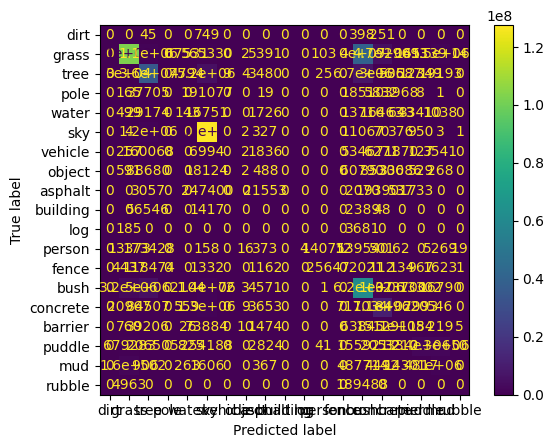

Class			IoU
dirt			0.00
grass			65.36
tree			63.57
pole			0.00
water			0.07
sky			92.39
vehicle			0.00
object			0.00
asphalt			4.34
building			0.00
log			0.00
person			4.03
fence			0.00
bush			50.80
concrete			52.75
barrier			3.87
puddle			39.44
mud			14.38
rubble			0.00


In [10]:
# Calculate metrics on the test set
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

with tf.device("/cpu:0"):
    dense_net = tf.keras.models.load_model("dense_net_final_proj.tf")
    dense_net.evaluate(test, batch_size=BATCH_SIZE)
    y_pred = dense_net.predict(x_test, batch_size=BATCH_SIZE)

reshape_x, reshape_y = y_test.shape[0] * y_test.shape[1] * y_test.shape[2], y_test.shape[3]
reshape_x, reshape_y = np.argmax(y_test.reshape(reshape_x, reshape_y), axis=-1), np.argmax(y_pred.reshape(reshape_x, reshape_y), axis=-1)

# Classification Report
print(classification_report(reshape_x, reshape_y, target_names=ontology_labels))

# Confusion Matrix
con_matrix = confusion_matrix(reshape_x, reshape_y)
con_disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix, display_labels=ontology_labels)
plt.figure(figsize=(25, 25))
con_disp.plot()
plt.show()

# IoU Per Class
false_neg, false_pos = np.sum(con_matrix, axis=0), np.sum(con_matrix, axis=1)
print("Class\t\t\tIoU")
for i, clas in enumerate(ontology_labels):
    tp = con_matrix[i, i]
    iou = tp / (tp+ (false_pos[i] - tp) + (false_neg[i] - tp))
    print("%s\t\t\t%.2f" % (clas, iou * 100))

1/1 [==============================] - 2s 2s/step


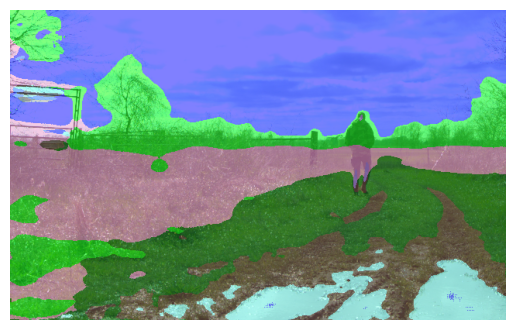

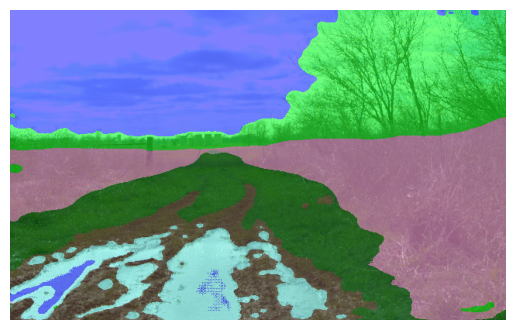

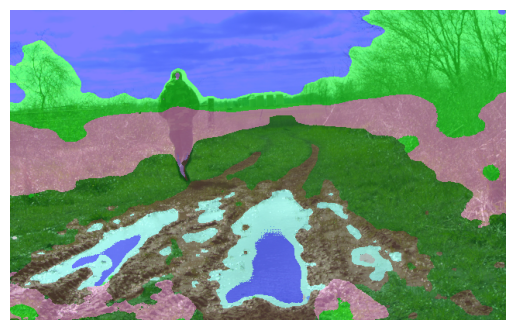

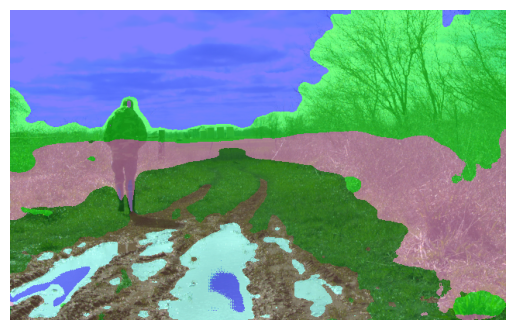

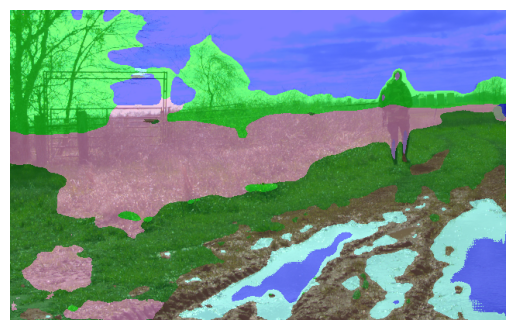

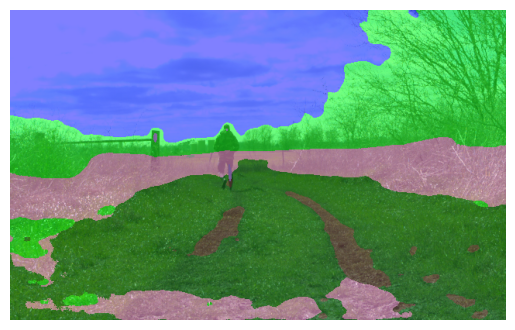

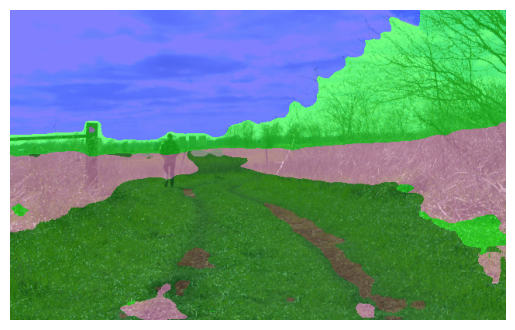

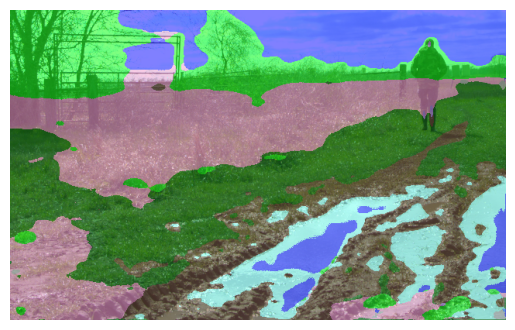

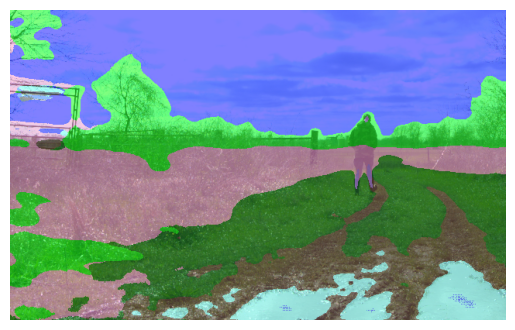

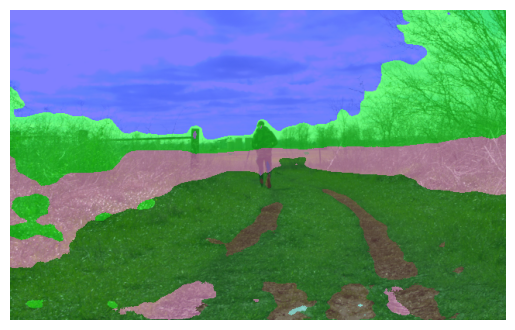

In [12]:
# Display 5 test images
with tf.device("/cpu:0"):
    for original, image in zip(x_test[0:10, :, :], dense_net.predict(x_test[0:10, :, :])):
        colored_image = np.argmax(image, axis=-1)
        colored_image = np.array(list(colors.values()))[colored_image]
        plt.imshow(original.astype(np.float32))
        plt.imshow(colored_image, alpha=0.5)
        plt.axis("off")
        plt.show()